1. Importar librerías y configuraciones

In [1]:
import pandas as pd
import numpy as np
import re
import time
from unicodedata import normalize

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Ajustes de visualización
sns.set()  # estilo Seaborn (opcional)
plt.rcParams["figure.figsize"] = (8, 5)

2. Cargar y explorar el dataset


=== Proporción de clases después del recorte ===
label
3    0.281859
4    0.277039
5    0.277039
2    0.089262
1    0.074801
Name: proportion, dtype: float64
=== Tamaño de df_train_bal ===
(54144, 2)

=== Info df_train_bal ===
<class 'pandas.core.frame.DataFrame'>
Index: 54144 entries, 4879 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    54144 non-null  object
 1   label   54144 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB

=== Valores nulos (df_train_bal) ===
text     0
label    0
dtype: int64

=== Distribución de etiquetas (df_train_bal) ===
label
3    15261
4    15000
5    15000
2     4833
1     4050
Name: count, dtype: int64


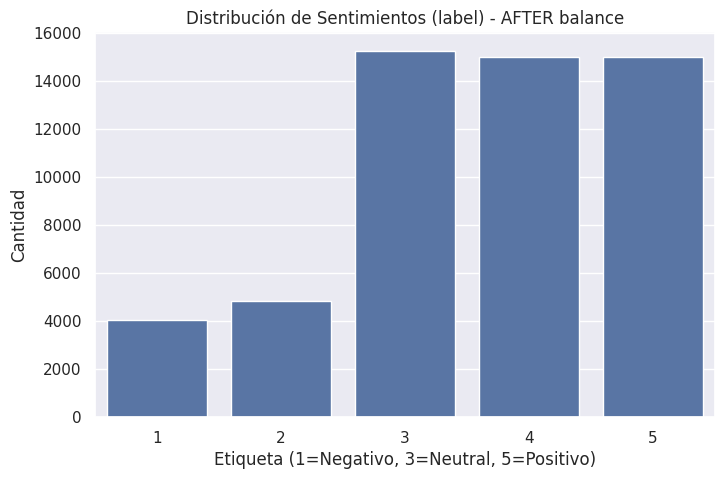


=== Estadísticas de longitud de texto (df_train_bal) ===
count    54144.000000
mean       431.383662
std        463.863926
min         40.000000
25%        219.000000
50%        295.000000
75%        513.250000
max      14197.000000
Name: long_texto, dtype: float64


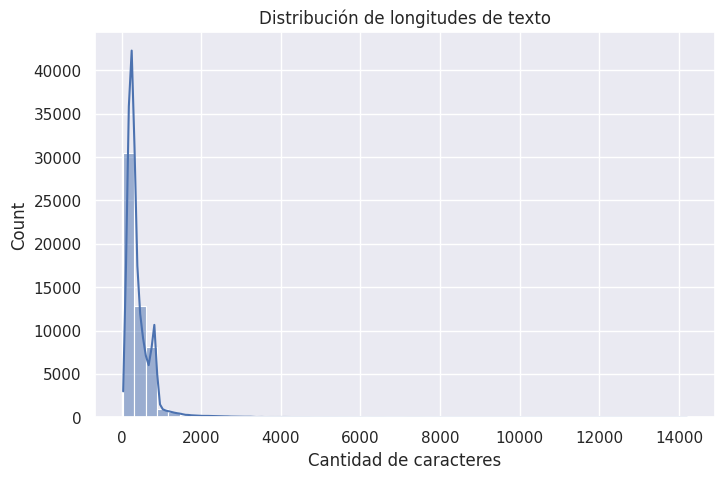

In [14]:
df_train = pd.read_parquet("/home/carizac/documnetos/proyecto_nlp/train-00000-of-00001-40d9940488cb84b1.parquet")

df_4 = df_train[df_train["label"] == 4].sample(n=15000, random_state=42)
df_5 = df_train[df_train["label"] == 5].sample(n=15000, random_state=42)
df_rest = df_train[~df_train["label"].isin([4,5])]
df_train_bal = pd.concat([df_4, df_5, df_rest], ignore_index=True).sample(frac=1, random_state=42)

print("\n=== Proporción de clases después del recorte ===")
print(df_train_bal["label"].value_counts(normalize=True))

print("=== Tamaño de df_train_bal ===")
print(df_train_bal.shape)

print("\n=== Info df_train_bal ===")
df_train_bal.info()

print("\n=== Valores nulos (df_train_bal) ===")
print(df_train_bal.isnull().sum())

print("\n=== Distribución de etiquetas (df_train_bal) ===")
print(df_train_bal['label'].value_counts())

sns.countplot(data=df_train_bal, x='label')
plt.title("Distribución de Sentimientos (label) - AFTER balance")
plt.xlabel("Etiqueta (1=Negativo, 3=Neutral, 5=Positivo)")
plt.ylabel("Cantidad")
plt.show()

df_train_bal["long_texto"] = df_train_bal["text"].apply(len)
print("\n=== Estadísticas de longitud de texto (df_train_bal) ===")
print(df_train_bal["long_texto"].describe())

sns.histplot(df_train_bal["long_texto"], bins=50, kde=True)
plt.title("Distribución de longitudes de texto")
plt.xlabel("Cantidad de caracteres")
plt.show()

3. Definir la función para limpiar texto

In [15]:
def limpiar_texto(text):
    """ Limpia y normaliza el texto:
        - Convierte a minúsculas
        - Elimina tildes y ñ
        - Remueve caracteres especiales
    """
    # 1) Minúsculas
    text = text.lower()
    
    # 2) Eliminar tildes y ñ
    text = normalize("NFD", text).encode("ascii", "ignore").decode("utf-8")
    
    # 3) Quitar caracteres especiales (solo letras, dígitos y espacios)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    return text



In [16]:
# Aplicar limpieza
df_train_bal["texto_limpio"] = df_train_bal["text"].apply(limpiar_texto)

# Verificación 1: Nulls
print("NaNs en texto_limpio:", df_train_bal["texto_limpio"].isnull().sum())
assert df_train_bal["texto_limpio"].isnull().sum() == 0, "❌ Hay textos vacíos después de la limpieza"

# Verificación 2: Vista rápida de ejemplos
for i in range(3):
    print(f"\nOriginal {i}: {df_train_bal.loc[i, 'text']}")
    print(f"Limpio   {i}: {df_train_bal.loc[i, 'texto_limpio']}")


NaNs en texto_limpio: 0

Original 0: muy recomendable. caminar en las tardes por sus arcos, sentarse un rato en las bancas y admirar sus jardines, no te preocupes por los automóviles, ya que cierran parte del zócalo para los transeúntes, muchas gracias al municipio por esta oportunidad de admirar el zócalo.
Limpio   0: muy recomendable caminar en las tardes por sus arcos sentarse un rato en las bancas y admirar sus jardines no te preocupes por los automoviles ya que cierran parte del zocalo para los transeuntes muchas gracias al municipio por esta oportunidad de admirar el zocalo

Original 1: chiles en nogada. muy buenos chiles en nogada con el detalle de nogada extra sol ricos porción basta muy recomendables
Limpio   1: chiles en nogada muy buenos chiles en nogada con el detalle de nogada extra sol ricos porcion basta muy recomendables

Original 2: impresionante entrada del puerto. no fui a el puerto fortificado entrada y torre/faro pero dos veces caminamos hasta ribera en el otro lad

4. Aplicar la limpieza con validaciones

In [18]:
# Aplicar limpieza
df_train_bal["texto_limpio"] = df_train_bal["text"].apply(limpiar_texto)

# Ver algunos ejemplos
print("\n=== Ejemplos de texto original vs. texto_limpio ===")
for i in range(3):
    print(f"Texto original [{i}]:", df_train_bal.loc[i, "text"])
    print(f"Texto limpio   [{i}]:", df_train_bal.loc[i, "texto_limpio"])
    print("--------------------------------------------------")

# Verificar si hay NaNs en texto_limpio
na_count = df_train_bal["texto_limpio"].isnull().sum()
print(f"\nNaNs en 'texto_limpio': {na_count}")

# Mostrar filas con texto_limpio nulo (si existieran)
if na_count > 0:
    df_na = df_train_bal[df_train_bal["texto_limpio"].isnull()]
    print("\n=== Filas con texto_limpio nulo ===")
    display(df_na.head(10))

# Validación estricta
assert na_count == 0, "Hay textos vacíos después de la limpieza"



=== Ejemplos de texto original vs. texto_limpio ===
Texto original [0]: muy recomendable. caminar en las tardes por sus arcos, sentarse un rato en las bancas y admirar sus jardines, no te preocupes por los automóviles, ya que cierran parte del zócalo para los transeúntes, muchas gracias al municipio por esta oportunidad de admirar el zócalo.
Texto limpio   [0]: muy recomendable caminar en las tardes por sus arcos sentarse un rato en las bancas y admirar sus jardines no te preocupes por los automoviles ya que cierran parte del zocalo para los transeuntes muchas gracias al municipio por esta oportunidad de admirar el zocalo
--------------------------------------------------
Texto original [1]: chiles en nogada. muy buenos chiles en nogada con el detalle de nogada extra sol ricos porción basta muy recomendables
Texto limpio   [1]: chiles en nogada muy buenos chiles en nogada con el detalle de nogada extra sol ricos porcion basta muy recomendables
-----------------------------------------

5. Dividir en entrenamiento y validación

In [5]:
X = df_train["texto_limpio"]
y = df_train["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

6. Vectorizar (TF-IDF)

In [ ]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # unigrams y bigrams
    max_df=0.95,
    min_df=2,
    max_features=5000   # <- Fija un límite 
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print("\n=== Vectorización TF-IDF completada con max_features===")
print("Tamaño X_train_tfidf:", X_train_tfidf.shape)
print("Tamaño X_val_tfidf:", X_val_tfidf.shape)


=== Vectorización TF-IDF completada con max_features===
Tamaño X_train_tfidf: (24666, 10000)
Tamaño X_val_tfidf: (10572, 10000)


7. Entrenar modelo (LogisticRegression)

In [ ]:
print("\n=== Entrenando modelo ===")
start = time.time()

modelo = LogisticRegression(
    solver='saga',
    max_iter=3000,
    class_weight='balanced',
    random_state=42
)
modelo.fit(X_train_tfidf, y_train)

end = time.time()
print(f"Entrenamiento completado en {end - start:.2f} segundos.")


=== Entrenando modelo ===
Entrenamiento completado en 68.37 segundos.


/home/carizac/documnetos/proyecto_nlp/venv_nlp/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


8. Evaluar (Classification Report + Confusion Matrix)


=== Evaluación en set de validación ===

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           1     0.7059    0.0513    0.0956       234
           2     0.0717    0.9137    0.1329       278
           3     0.2909    0.1939    0.2327       944
           4     0.5053    0.0744    0.1298      2539
           5     0.8018    0.7326    0.7656      6577

    accuracy                         0.5161     10572
   macro avg     0.4751    0.3932    0.2713     10572
weighted avg     0.6637    0.5161    0.5339     10572



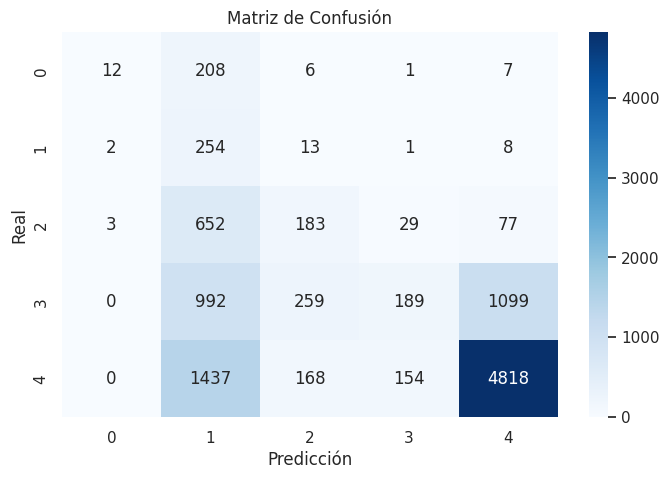

✅ Pipeline de análisis de sentimientos completo con validaciones.


In [8]:
print("\n=== Evaluación en set de validación ===")
y_pred = modelo.predict(X_val_tfidf)

# Reporte de clasificación
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_val, y_pred, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

print("✅ Pipeline de análisis de sentimientos completo con validaciones.")